In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# Part 1

In [2]:
def deriv_I(d,alpha,beta):
    Io = 100*(1-(beta+0.1))
    return -(Io*np.exp(-d/alpha))/alpha

def deriv_Ah(depth,h,A):
    A_max = A[0]
    A_depth = A[1]
    A_dip = A[2]
    if depth < h:
        return A_max
    else:
        return  A_depth + (A_max-A_depth-A_dip*(depth-h))*np.exp(-0.5*(depth-h))
    #return A_depth + (A_max-A_depth-A_dip*(depth-h))*np.exp(-0.5*(depth-h))
    
def n_matrix(N,h):
    A_max = 1e-2
    A = np.zeros(shape=(N+1,N+1))

    # Evaluated d/dd[Ah dT/dd] as a whole (check notes)
    for i in range(1,N):
        z1 = deriv_Ah(i-0.5,h) 
        z2 = (deriv_Ah(i+0.5,h) + deriv_Ah(i-0.5,h))
        z3 = deriv_Ah(i+0.5,h) 
        A[i,i-1:3+(i-1)] = [z1,-z2,z3]
    return A 


In [3]:

N = 200
h = 10
A = n_matrix(N,h)

# Setting up initial conditions
A[0,0] = 1 
A[-1,-1] = 1 

np.set_printoptions(linewidth=100)
A

array([[ 1.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00,  0.e+00],
       [ 1.e-02, -2.e-02,  1.e-02, ...,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00,  1.e-02, -2.e-02, ...,  0.e+00,  0.e+00,  0.e+00],
       ...,
       [ 0.e+00,  0.e+00,  0.e+00, ..., -2.e-04,  1.e-04,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  1.e-04, -2.e-04,  1.e-04],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00,  1.e+00]])

In [4]:
np.linalg.cond(A)

35826502.626092196

In [5]:
alpha = 10
cp = 4e6

T = np.zeros(N+1).reshape((N+1),1)
F = np.zeros(N+1).reshape((N+1),1)
F[0] = -1 
F[-1] = -2

for d in range(1,N):
    F[d] = (1/cp * deriv_I(d,alpha))
    

In [6]:
T = np.linalg.solve(A,F)
len(T[:,0])
depth = np.arange(len(T[:,0]))

(200.0, 0.0)

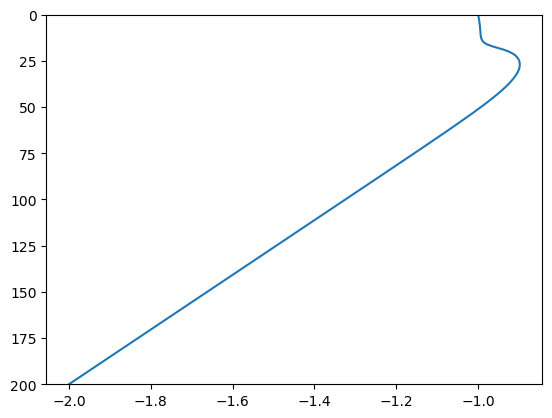

In [7]:
plt.plot(T,depth)
plt.ylim(200,0)
#plt.xlim(-3,1)

# Part 2

## Scenario 1 

In [8]:
def deriv_T(A,T,F):
    return np.matmul(A,T)-F

In [9]:
Ntime = 500 # seconds
dt = 10 # seconds 
timeVec = np.arange(0,Ntime,dt)
#deriv_T = np.dot(A,T)-F


In [10]:
# move forward in time with Feuler
Tn = []
T1 = np.linalg.solve(A,F)
for i in range(len(timeVec)):
    Tnew = T1 + dt*(deriv_T(A,T1,F))
    Tn.append(Tnew)
    T1 = Tnew
Tn = np.array(Tn)

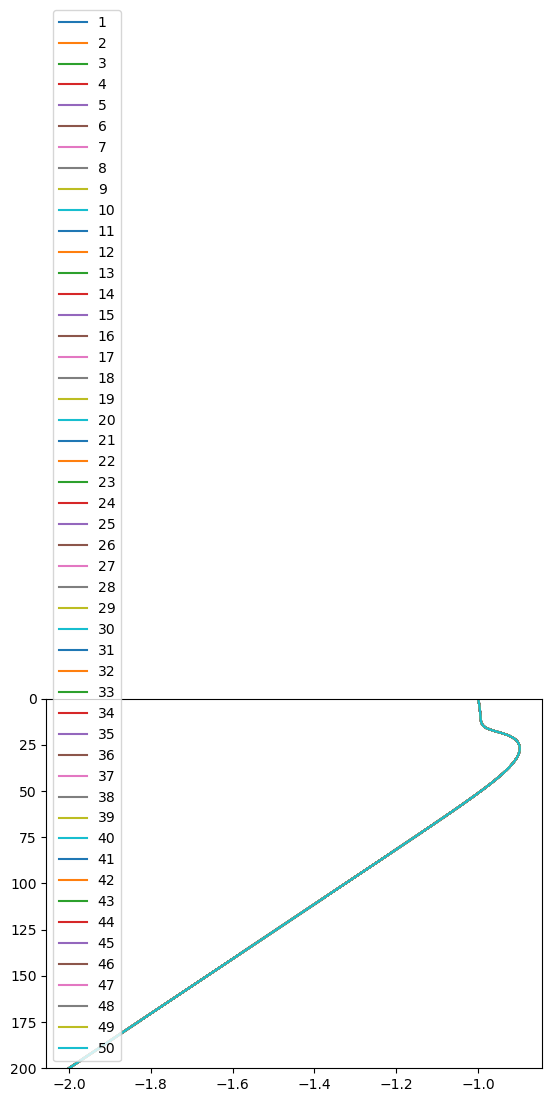

In [11]:
for i in range(np.shape(Tn)[0]):
    plt.plot(Tn[i,:],depth,label=i+1)
plt.ylim(200,0)
plt.legend(loc='best')

## Scenario 2

(200.0, 0.0)

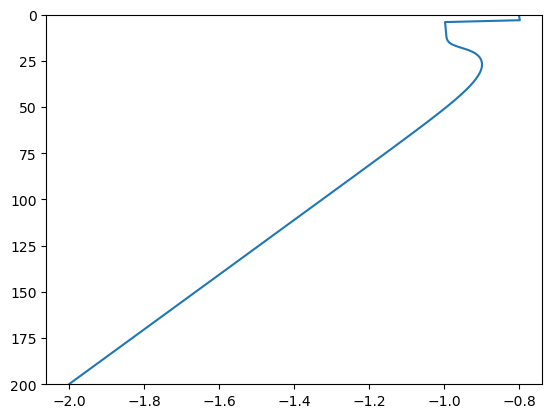

In [12]:
T2 = np.linalg.solve(A,F) 
T2[:4] = T2[:4]+0.2
plt.plot(T2,depth)
plt.ylim(200,0)

In [13]:
Tn_surf_heat = []
for i in range(len(timeVec)):
    Tnew = T2 + dt*deriv_T(A,T2,F)
    Tnew[0] = Tnew[1]
    Tnew[-1] = Tnew[-2]
    Tn_surf_heat.append(Tnew)
    T2 = Tnew
Tn_surf_heat = np.array(Tn_surf_heat)

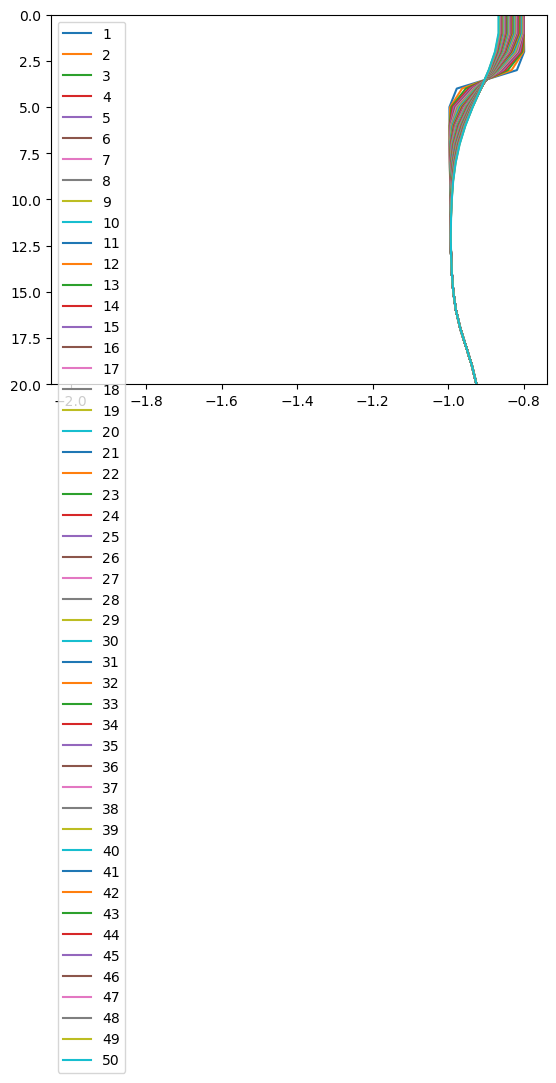

In [14]:
for i in range(np.shape(Tn_surf_heat)[0]):
    plt.plot(Tn_surf_heat[i,:],depth,label=i+1)
plt.ylim(20,0)
plt.legend(loc='best')

## Scenario 3

(200.0, 0.0)

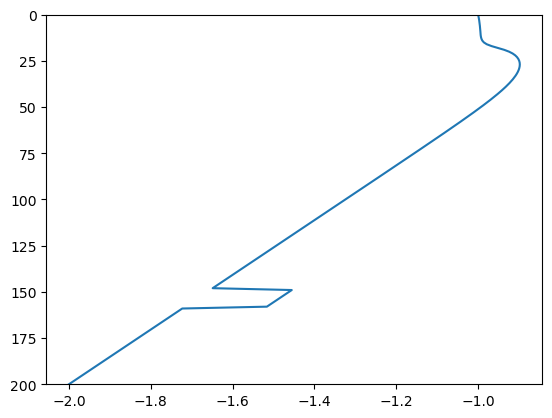

In [15]:
T3 = np.linalg.solve(A,F) 
T3[149:159] = T3[149:159]+0.2
plt.plot(T3,depth)
plt.ylim(200,0)

In [16]:
Ntime = 20000 # seconds
dt = 10 # seconds 
timeVec = np.arange(0,Ntime,dt)
#deriv_T = np.dot(A,T)-F

In [17]:
Tn_bot_heat = []
for i in range(len(timeVec)):
    Tnew = T3 + dt*deriv_T(A,T3,F)
    Tnew[0] = Tnew[1]
    Tnew[-1] = Tnew[-2]
    Tn_bot_heat.append(Tnew)
    T3 = Tnew
Tn_bot_heat = np.array(Tn_bot_heat)

(160.0, 140.0)

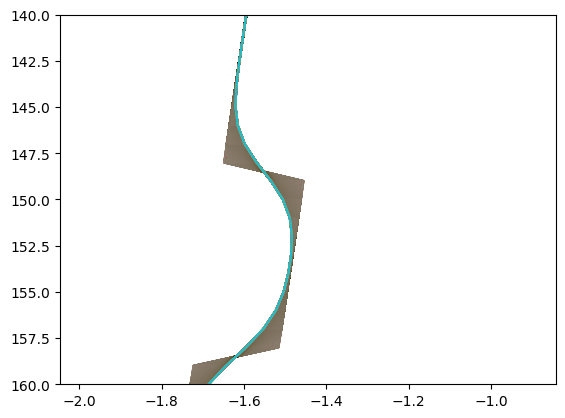

In [19]:
for i in range(np.shape(Tn_bot_heat)[0]):
    plt.plot(Tn_bot_heat[i,:],depth,label=i+1)
plt.ylim(160,140)
#plt.legend(loc='best')